In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.stats

# Acceptance-rejection sampling

- generate $10^6$ points uniformly within $-1, 1$ square
- compute fraction $r$ of points within a unit circle
- repeat for different dimension numbers $d: 2, 3, 4, ..., 15$
- plot $r$ as a function of $d$
- assign an uncertainty to $r$ estimation
- compare with theoretical expectation for $r$
  - $n$-ball volume: $V_n(R) = \frac{\pi^{n / 2}}{\Gamma(n/2 + 1)} R^n$
  - theoretical limit value $r = \frac{V_n(1)}{2^n}$


In [20]:
def log_factorial(n: int) -> int:
    return sum(np.log(i) for i in range(1, n + 1))


def r_theoredical(d: int) -> int:
    return np.exp(
        d / 2 * np.log(np.pi) - scipy.special.loggamma(d / 2 + 1) - d * np.log(2)
    )

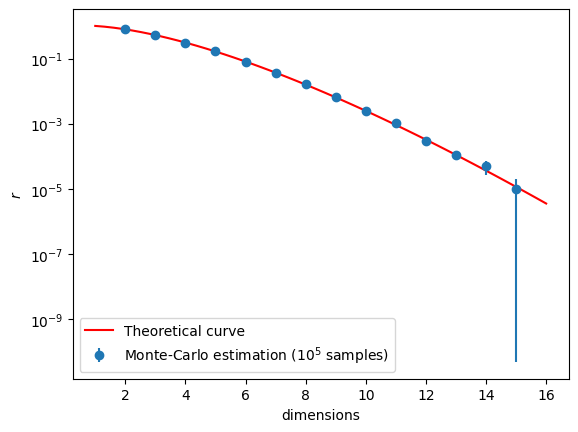

In [21]:
SAMPLE_SIZE = int(1e5)

fig, ax = plt.subplots()

d_max = 15
d_sample = list(range(2, d_max + 1))
r_estimations = []
r_errors = []
for d in d_sample:
    points = np.random.uniform(low=-1, high=1, size=(SAMPLE_SIZE, d))
    success_count = np.count_nonzero((points**2).sum(axis=1) < 1)
    r_est = success_count / SAMPLE_SIZE
    r_estimations.append(r_est)
    r_errors.append(np.sqrt(SAMPLE_SIZE * r_est * (1 - r_est)) / SAMPLE_SIZE)

d_range = np.linspace(1, d_max + 1)
ax.plot(
    d_range,
    [r_theoredical(d) for d in d_range],
    color="r",
    label="Theoretical curve",
)

ax.errorbar(
    d_sample,
    r_estimations,
    r_errors,
    fmt="o",
    label=f"Monte-Carlo estimation ($10^{{{int(np.log10(SAMPLE_SIZE))}}}$ samples)",
)

ax.set_yscale("log")
ax.set_xlabel("dimensions")
ax.set_ylabel("$r$")
ax.legend()

plt.show()

# Random number correlation

- generate $1 + 10^5$ numbers $x_i$ distributed $\sim \mathcal{N}(3, 2)$
- plot the distribution of $x_i$ and of $x_i - x_{i - 1}$
- do the same but with MCMC algorithm
  - use $\mathcal{N}(x_0, 0.3)$ as proposal distribution
- can we explain standard deviation of the distribution of $x_i - x_{i-1}$ for two cases?


In [22]:
import itertools
from typing import Callable


def sample_mcmc(
    pdf: Callable[[float], float],
    initial: float,
    size: int,
    burn_in_steps: int = 0,
    thinning: int = 1,
) -> list[float]:
    sample: list[float] = []
    current = initial
    for step in itertools.count():
        next_ = np.random.normal(loc=current, scale=0.3)
        if pdf(next_) / pdf(current) > np.random.uniform():
            current = next_
            if step > burn_in_steps and (step - burn_in_steps) % thinning == 0:
                sample.append(current)
            if len(sample) >= size:
                return sample

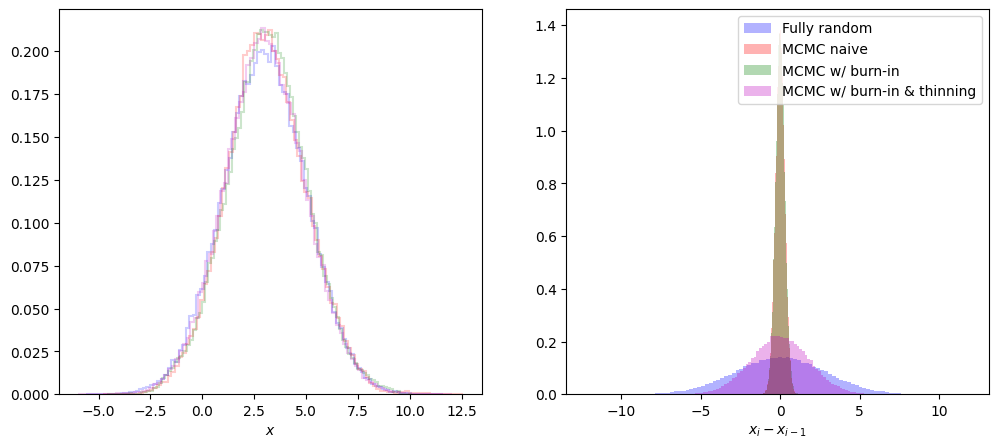

In [23]:
SAMPLE_SIZE = int(1e5) + 1
target_rv = scipy.stats.norm(loc=3, scale=2)
fully_random_sample = target_rv.rvs(size=SAMPLE_SIZE)
mcmc_naive_sample = np.array(
    sample_mcmc(pdf=target_rv.pdf, initial=0, size=SAMPLE_SIZE)
)
mcmc_burn_in_sample = np.array(
    sample_mcmc(
        pdf=target_rv.pdf,
        initial=0,
        size=SAMPLE_SIZE,
        burn_in_steps=1000,
    )
)
mcmc_burn_in_thinned_sample = np.array(
    sample_mcmc(
        pdf=target_rv.pdf,
        initial=0,
        size=SAMPLE_SIZE,
        burn_in_steps=1000,
        thinning=50,
    )
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

for label, color, sample in [
    ("Fully random", "b", fully_random_sample),
    ("MCMC naive", "r", mcmc_naive_sample),
    ("MCMC w/ burn-in", "g", mcmc_burn_in_sample),
    ("MCMC w/ burn-in & thinning", "m", mcmc_burn_in_thinned_sample),
]:
    ax1.hist(
        sample,
        bins=100,
        alpha=0.2,
        color=color,
        density=True,
        label=label,
        histtype="step",
        linewidth=1.5,
    )
    ax2.hist(
        sample[1:] - sample[:-1],
        bins=100,
        alpha=0.3,
        color=color,
        density=True,
        label=label,
    )

ax1.set_xlabel("$x$")
ax2.set_xlabel("$x_i - x_{i-1}$")
ax2.legend()

plt.show()